# Two Rectangles Detection

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Generation

In [18]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_rect_size, max_rect_size, size = 2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x + w, y:y + h] = 1.
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 2, 4))

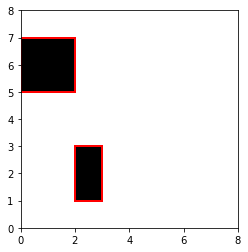

In [19]:
i = 0
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r', fc = 'none'))
plt.savefig('two-rectangles_data.png', dpi = 100)

## Preprocessing

In [20]:
# Reshape and normalize the data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 2.2133406218927122e-17, 1.0)

In [21]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 8), 0.2809125, 0.17491483240065722)

## Train Test Split

In [22]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [23]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
        ])
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 18,696
Trainable params: 18,696
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [24]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating function

In [25]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [26]:
# Since the model won't know which box to predict first, we have to switch bboxes during training.
# Note: The validation loss is always quite big here because we don't switch the bounding boxes for the validation data. 

num_epochs = 50
switched_train_y = np.array(train_y)
switched = np.zeros((len(switched_train_y), num_epochs))
ious_epoch = np.zeros((len(switched_train_y), num_epochs))
dists_epoch = np.zeros((len(switched_train_y), num_epochs))
mses_epoch = np.zeros((len(switched_train_y), num_epochs))

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    model.fit(train_X, switched_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1,
              callbacks = [ModelCheckpoint('Two_Rectangles_model.h5',
                                           monitor = 'val_accuracy',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)
    
    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, switched_train_y)):
        
        switched_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_switched = np.mean(np.square(pred_bboxes - switched_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_switched = IOU(pred_bboxes[:4], switched_exp_bboxes[:4]) + IOU(pred_bboxes[4:], switched_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[4:], exp_bboxes[4:])
        dist_switched = distance(pred_bboxes[:4], switched_exp_bboxes[:4]) + distance(pred_bboxes[4:], switched_exp_bboxes[4:])
        
        if mse_switched < mse:  # you can also use iou or dist here
            switched_train_y[i] = switched_exp_bboxes
            switched[i, epoch] = 1
            mses_epoch[i, epoch] = mse_switched / 2.
            ious_epoch[i, epoch] = iou_switched / 2.
            dists_epoch[i, epoch] = dist_switched / 2.
        else:
            mses_epoch[i, epoch] = mse / 2.
            ious_epoch[i, epoch] = iou / 2.
            dists_epoch[i, epoch] = dist / 2.
            
    print('Switched {} training samples ({} %)'.format(np.sum(switched[:, epoch]), np.mean(switched[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))

Epoch:  0
1250/1250 [==============================] - 1s 920us/step - loss: 0.0472 - accuracy: 0.2779 - val_loss: 0.0184 - val_accuracy: 0.3298
Switched 19255.0 training samples (48.1375 %)
Mean IOU: 0.17139559832046844
Mean dist: 0.2022666551474687
Mean mse: 0.008365470404598369
Epoch:  1
1250/1250 [==============================] - 1s 997us/step - loss: 0.0167 - accuracy: 0.4526 - val_loss: 0.0191 - val_accuracy: 0.3511
Switched 8146.0 training samples (20.365 %)
Mean IOU: 0.2184023200064336
Mean dist: 0.16513168040168508
Mean mse: 0.006012877709147831
Epoch:  2
1250/1250 [==============================] - 1s 872us/step - loss: 0.0125 - accuracy: 0.5567 - val_loss: 0.0218 - val_accuracy: 0.3755
Switched 4376.0 training samples (10.94 %)
Mean IOU: 0.30545837805076037
Mean dist: 0.1273614912063631
Mean mse: 0.004225262831310145
Epoch:  3
1250/1250 [==============================] - 1s 887us/step - loss: 0.0102 - accuracy: 0.6136 - val_loss: 0.0229 - val_accuracy: 0.3923
Switched 2618.

1250/1250 [==============================] - 1s 861us/step - loss: 0.0057 - accuracy: 0.7188 - val_loss: 0.0262 - val_accuracy: 0.4238
Switched 654.0 training samples (1.635 %)
Mean IOU: 0.5048910268676522
Mean dist: 0.06374810823794283
Mean mse: 0.0016309107338702547
Epoch:  30
1250/1250 [==============================] - 1s 891us/step - loss: 0.0057 - accuracy: 0.7143 - val_loss: 0.0259 - val_accuracy: 0.4290
Switched 602.0 training samples (1.505 %)
Mean IOU: 0.506276924970862
Mean dist: 0.06238126724032048
Mean mse: 0.0015838676936582485
Epoch:  31
1250/1250 [==============================] - 1s 872us/step - loss: 0.0057 - accuracy: 0.7151 - val_loss: 0.0261 - val_accuracy: 0.4186
Switched 660.0 training samples (1.6500000000000001 %)
Mean IOU: 0.5053512528823366
Mean dist: 0.06467605072023798
Mean mse: 0.0016278682677267355
Epoch:  32
1250/1250 [==============================] - 1s 847us/step - loss: 0.0056 - accuracy: 0.7158 - val_loss: 0.0256 - val_accuracy: 0.4216
Switched 602.

## Switching Track

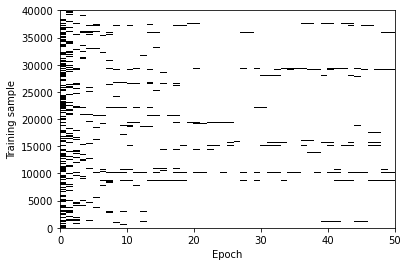

In [32]:
# Show switchings for a few training samples.
'''Differences between pcolor() and pcolormesh(): 
   pcolormesh() is more specialized for the given purpose and thus is faster. It should almost always be preferred.'''
plt.pcolormesh(switched[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('two-rectangles_switches.png', dpi = 100)
plt.show()

## Metrics Track

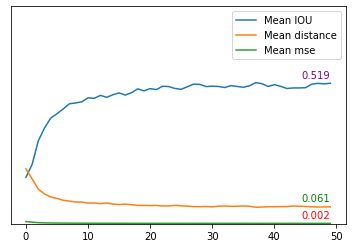

In [28]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis = 0)
mean_dists_epoch = np.mean(dists_epoch, axis = 0)
mean_mses_epoch = np.mean(mses_epoch, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')
# horizontalalignment = 'right': make the annotation text aligns with the right side
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'purple')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.8)
plt.savefig('training_metrics.png', dpi = 100)

## Denormalize Data

In [29]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 2, 4)

## Visualize Results

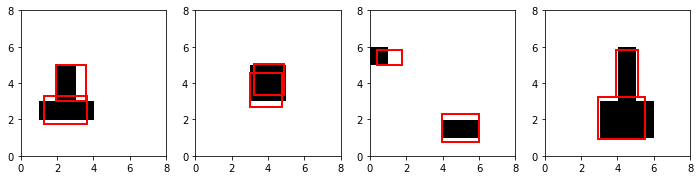

In [30]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize = (12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r', fc = 'none'))

plt.savefig('two-rectangles_with-switching.png', dpi = 100)

## Overall Assessment

In [31]:
from keras.models import load_model
model_test = load_model('Two_Rectangles_model.h5')
pred_y = model_test.predict(test_X)
summed_IOU = 0.

for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, test_y)):

    switched_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])

    iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
    iou_switched = IOU(pred_bboxes[:4], switched_exp_bboxes[:4]) + IOU(pred_bboxes[4:], switched_exp_bboxes[4:])

    if iou_switched > iou:  
        summed_IOU += iou_switched
    else:
        summed_IOU += iou

mean_IOU = summed_IOU / (num_objects * len(pred_y))
mean_IOU

0.5165961587354475